In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:
# Load Dataset
df = pd.read_csv('UTSClustering.csv', encoding='ISO-8859-1')


In [12]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [13]:
df.dropna(subset=['Description', 'CustomerID'], inplace=True) # Hapus baris yang tidak memiliki CustomerID atau Description
# Hanya ambil transaksi dengan Quantity dan UnitPrice positif
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [15]:
# Feature Engineering
# Konversi InvoiceDate ke datetime dan ekstraksi fitur waktu
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.dayofweek

In [7]:
# Aggregation by Customer
agg_df = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique',
    'Description': lambda x: ' '.join(x),
    'Hour': 'mean',
    'Weekday': 'mean',
    'Country': 'first'
}).reset_index()
agg_df.rename(columns={'InvoiceNo': 'NumTransactions'}, inplace=True)

In [22]:
# TF-IDF for Description
vectorizer = TfidfVectorizer(max_features=50)
desc_tfidf = vectorizer.fit_transform(agg_df['Description']).toarray()
desc_tfidf_df = pd.DataFrame(desc_tfidf, index=agg_df.index)

In [23]:
# Encode country
country_encoded = pd.get_dummies(agg_df['Country'], drop_first=True)

In [24]:
# Feature Matrix
features = pd.concat([
    agg_df[['Quantity', 'UnitPrice', 'NumTransactions', 'Hour', 'Weekday']],
    pd.DataFrame(desc_tfidf),
    country_encoded
], axis=1)

In [25]:
# Fix column names to ensure they are all strings
features.columns = features.columns.astype(str)

In [26]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [27]:
# Apply Clustering Algorithms
models = {
    'KMeans': KMeans(n_clusters=5, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=5),
    'DBSCAN': DBSCAN(eps=1.8, min_samples=5),
    'GMM': GaussianMixture(n_components=5, random_state=42),
    'Spectral': SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
}


In [28]:
results = {}

for name, model in models.items():
    if name == 'GMM':
        labels = model.fit_predict(X_scaled)
    else:
        labels = model.fit(X_scaled).labels_

    silhouette = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)

    results[name] = {
        'labels': labels,
        'silhouette': silhouette,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [29]:
# Visualization Function
def plot_silhouette(X, labels, title):
    from sklearn.metrics import silhouette_samples
    silhouette_vals = silhouette_samples(X, labels)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i in np.unique(labels):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette_vals.mean(), color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.show()

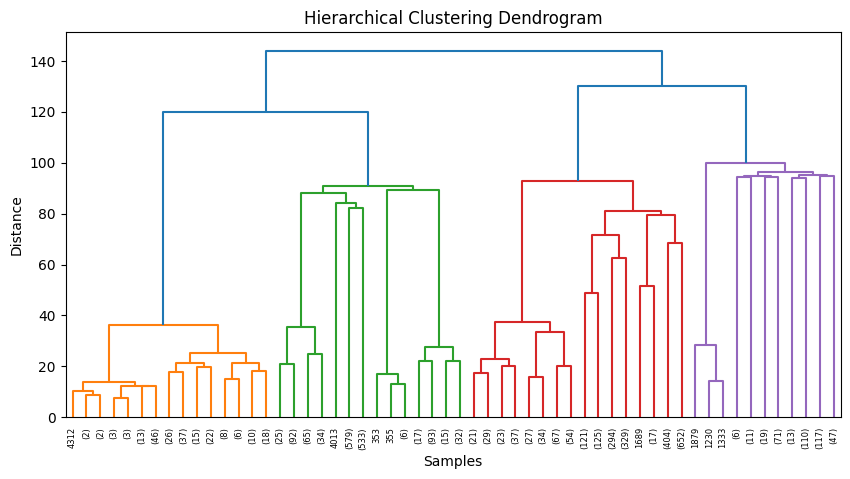

In [30]:
# Dendrogram for Agglomerative
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

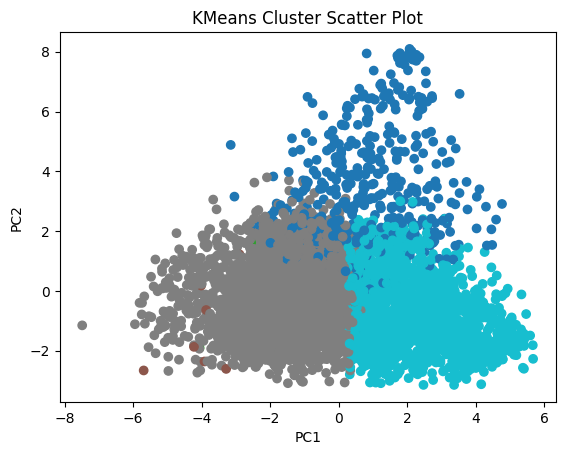

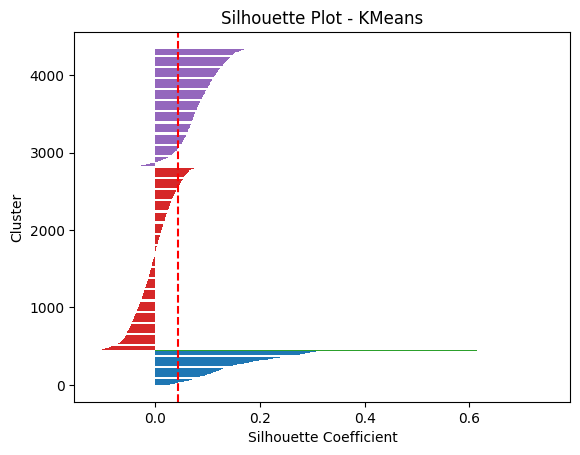

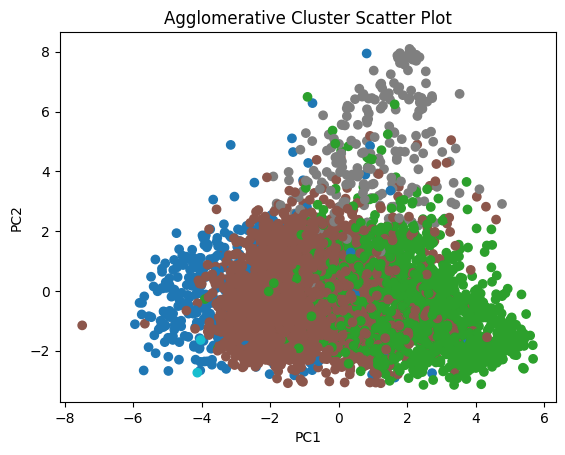

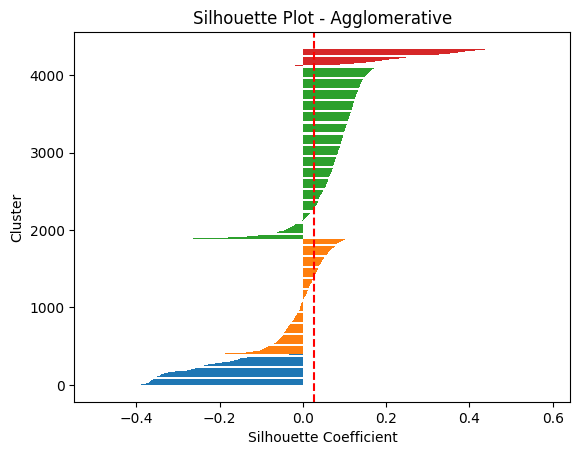

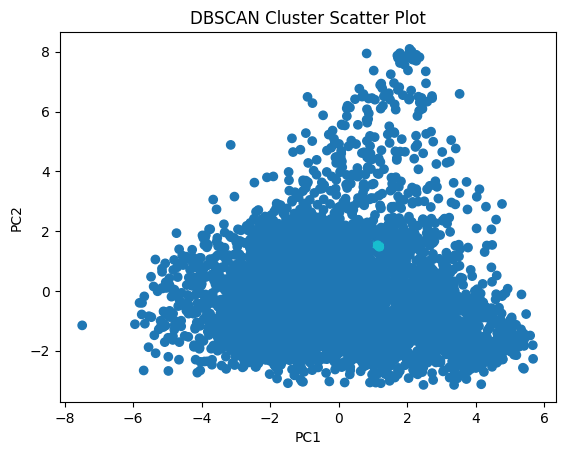

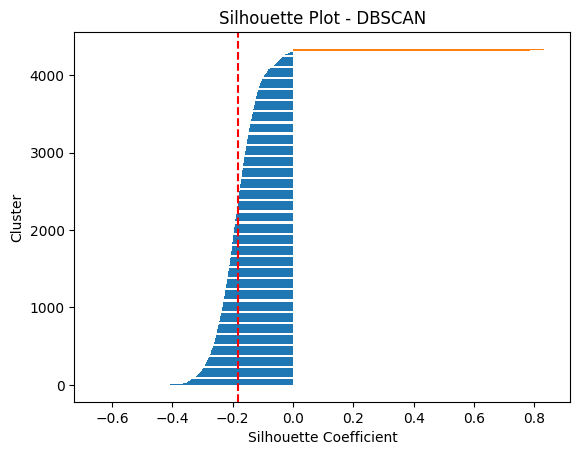

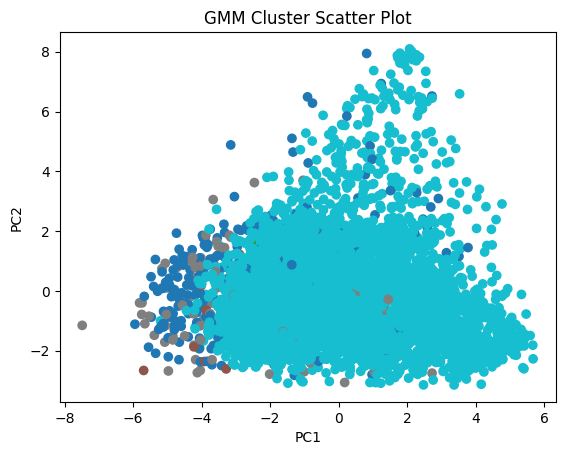

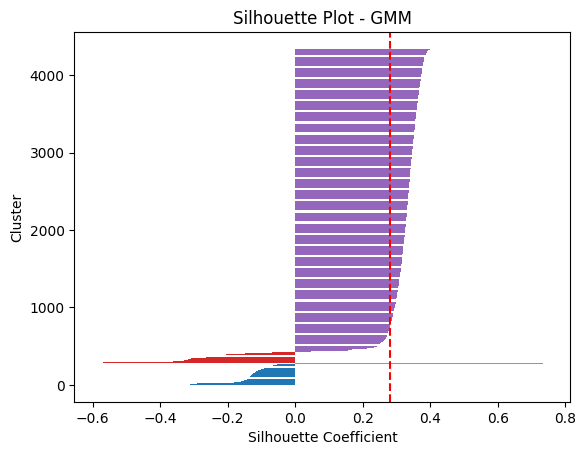

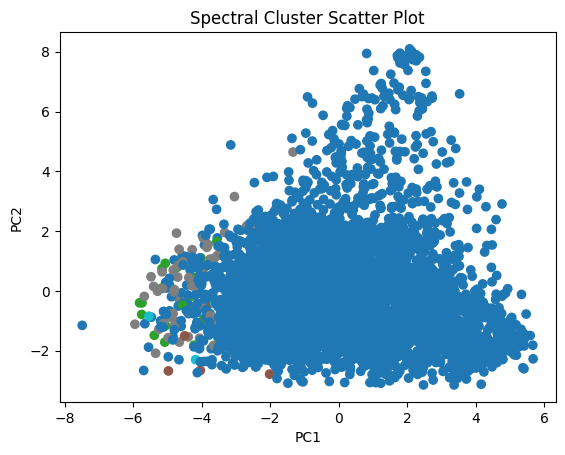

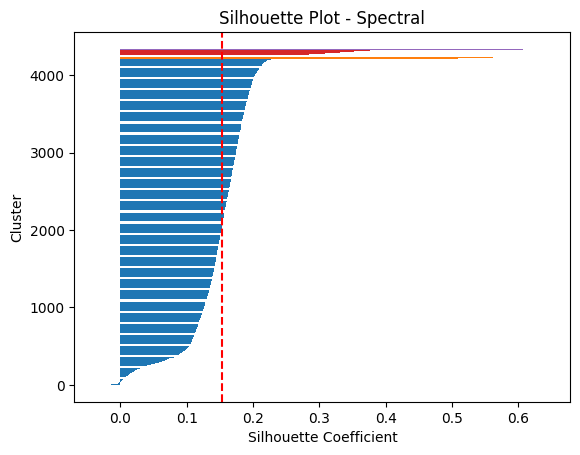

In [31]:
# PCA for 2D Scatter Plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for name in results:
    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=results[name]['labels'], cmap='tab10')
    plt.title(f'{name} Cluster Scatter Plot')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    plot_silhouette(X_scaled, results[name]['labels'], f'Silhouette Plot - {name}')


In [32]:
# Evaluation Summary
for name, metrics in results.items():
    print(f"\nModel: {name}")
    print(f"Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz Score: {metrics['calinski_harabasz']:.4f}")


Model: KMeans
Silhouette Score: 0.0437
Davies-Bouldin Index: 2.3849
Calinski-Harabasz Score: 96.6365

Model: Agglomerative
Silhouette Score: 0.0270
Davies-Bouldin Index: 3.4593
Calinski-Harabasz Score: 92.2458

Model: DBSCAN
Silhouette Score: -0.1820
Davies-Bouldin Index: 1.9778
Calinski-Harabasz Score: 8.6189

Model: GMM
Silhouette Score: 0.2817
Davies-Bouldin Index: 3.3273
Calinski-Harabasz Score: 63.2152

Model: Spectral
Silhouette Score: 0.1539
Davies-Bouldin Index: 1.1827
Calinski-Harabasz Score: 57.7333


## 📊 Analisis Hasil Clustering dan Jawaban Soal

### 1. **Silhouette Score KMeans Rendah meskipun Elbow Method K=5**
- **Masalah utama:** KMeans mengasumsikan bentuk cluster sferis.
- **Inkonsistensi:** Elbow Method menyarankan \( K = 5 \), namun nilai **Silhouette Score** hanya \( \approx 0.3 \) → cluster tumpang tindih.
- **Alternatif Validasi:**
  - **Gap Statistic**: Bandingkan variansi intra-cluster dengan data acak.
  - **Bootstrapping**: Menguji stabilitas cluster terhadap resampling.
- **Akar masalah:** Distribusi data non-spherical tidak cocok untuk jarak Euclidean → KMeans gagal menangkap struktur sebenarnya.

---

### 2. **Preprocessing Campuran Fitur Numerik & Kategorikal High-Cardinality**
- **Contoh fitur:**
  - Numerik: `Quantity`, `UnitPrice`
  - Kategorikal: `Description` (banyak nilai unik)
- **Masalah:** One-Hot Encoding pada `Description` → sparse matrix sangat besar dan overfitting.
- **Solusi:**
  - Gunakan **TF-IDF** untuk representasi teks berbobot.
  - **UMAP / PCA**: untuk reduksi dimensi dan mempertahankan struktur.
- **Skala:**
  - Numerik: `StandardScaler`
  - Teks: `TfidfVectorizer`
- **Kesimpulan:** Teknik TF-IDF dan embedding seperti UMAP lebih stabil dalam menjaga struktur klaster.

---

### 3. **Penentuan Epsilon DBSCAN Secara Adaptif**
- **Masalah:** Parameter \( \varepsilon \) terlalu besar → cluster bercampur; terlalu kecil → noise.
- **Solusi adaptif:**
  - **k-Distance Graph:** Plot jarak ke tetangga ke-\( k \), cari "elbow" untuk menentukan \( \varepsilon \).
  - Gunakan kuartil ke-3 dari distribusi jarak sebagai threshold awal.
- **MinPts:** Biasanya \( \text{MinPts} = 2 \times \text{dimensi} \), namun perlu disesuaikan jika data tidak seimbang (contoh: 90% dari UK).
- **Kesimpulan:** DBSCAN efektif untuk cluster berdensitas tinggi, tetapi perlu tuning parameter secara lokal.

---

### 4. **Overlap Cluster High-Value vs Bulk Buyers**
- **Masalah:** Kedua cluster memiliki pola pengeluaran tinggi → overlap signifikan.
- **Solusi:**
  - **Constrained Clustering:** Tambah pengetahuan domain (must-link / cannot-link).
  - **Metric Learning:** Gunakan jarak Mahalanobis untuk menangkap korelasi fitur.
- **Tantangan:** Mahalanobis dan model non-Euclidean sulit diinterpretasikan oleh bisnis.
- **Kesimpulan:** Trade-off antara pemisahan cluster dan interpretabilitas perlu diperhatikan.

---

### 5. **Feature Engineering Temporal & Risiko Leakage**
- **Strategi fitur:**
  - Ekstraksi: `Jam`, `Hari`, `Bulan`, `Akhir Pekan`, dll.
  - **Lag Feature:** Misalnya pembelian 7 hari terakhir.
- **Risiko:**
  - **Data Leakage:** Rata-rata pembelian bulanan bisa memakai data masa depan.
  - **Noise dari Lag:** Tidak semua pelanggan punya frekuensi pembelian rutin.
- **Solusi:** Gunakan **Time-Based Cross Validation** dan agregasi berbasis waktu historis.
- **Kesimpulan:** Fitur temporal berguna tetapi harus dibangun dengan hati-hati terhadap urutan waktu.

---

### 📌 Rangkuman Evaluasi Model

| Model              | Silhouette ↑ | Davies-Bouldin ↓ | Calinski-Harabasz ↑ |
|-------------------|--------------|------------------|----------------------|
| **KMeans**         | 0.0437       | 2.3849           | 96.64               |
| **Agglomerative**  | 0.0270       | 3.4593           | 92.25               |
| **DBSCAN**         | -0.1820      | 1.9778           | 8.62                |
| **GMM**            | **0.2817**   | 3.3273           | 63.22               |
| **Spectral**       | 0.1539       | **1.1827**       | 57.73               |

🟢 **Terbaik secara keseimbangan metrik: Gaussian Mixture Model (GMM)**  
🟡 **Terburuk: DBSCAN pada dataset ini**, karena parameter default tidak sesuai.

